<a href="https://colab.research.google.com/github/bi-horn/ML_Heart_Disease/blob/main/ML_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart disease prediction with ML algorithms

In [1]:
#Mount Google Drive
from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, log_loss, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
#from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# Importing data
data_path = '/content/drive/My Drive/heart_disease/data/preprocessed_data_chd.csv'

df = pd.read_csv(data_path)

In [6]:
df.head()

,age,education,sex,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,bmi,heart_rate,glucose,ten_year_chd,pulse_pressure
0,1.812913,2,0,0.602060,0,0,0,0,2.346353,1.421275,1.959041,1.908485,1,1.806180
1,1.568202,4,1,0.301030,0,0,1,0,2.328380,1.488127,1.863323,1.880814,0,1.851258
2,1.672098,1,0,1.041393,0,0,0,0,2.399674,1.329398,1.949390,1.977724,0,1.662758
3,1.707570,1,1,1.322219,0,0,1,0,2.369216,1.466274,1.838849,1.977724,1,1.851258
4,1.812913,1,0,1.491362,0,0,0,0,2.383815,1.438067,1.851258,1.892095,0,1.720159


In [7]:
#exclude all categorical variables or contonuous variables

cat_var = ['education', 'sex', 'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes', 'ten_year_chd']
cont_var = ['age', 'cigs_per_day', 'total_cholesterol', 'pulse_pressure', 'bmi', 'heart_rate', 'glucose']
dependent_var = ['ten_year_chd'] #label 0/1

# df with continuous variables only
df_cont = df.drop(columns=cat_var)

#df with categorical variables only
df_cat = df.drop(columns=cont_var)

## Train Test Split

In [8]:
# Split the data into training and testing dataset
dependent_var = ['ten_year_chd']
X = df.drop('ten_year_chd',axis=1)
y = df[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #70% training and 30% test

##### Handling the previously detected outliers

To remember:
For the feature age, number of outliers is 0

For the feature cigs_per_day, number of outliers is 17

For the feature total_cholesterol, number of outliers is 19

For the feature bmi, number of outliers is 46

For the feature heart_rate, number of outliers is 19

For the feature glucose, number of outliers is 42

For the feature pulse_pressure, number of outliers is 46

-> bmi, glucose and pulse pressure have the most outliers

Replacement of the outlier with median value

In [ ]:
X_train[cont_var].skew(axis = 0)

age                  0.001493
cigs_per_day         0.415730
total_cholesterol   -0.035148
pulse_pressure       0.317981
bmi                  0.322960
heart_rate           0.166288
glucose              2.421207
dtype: float64

In [9]:
# imputing the outliers beyond 3 standard deviations from the mean with its median value
for i in ['total_cholesterol', 'bmi', 'heart_rate', 'glucose','pulse_pressure']:
  upper_lim = X_train[i].mean() + 3 * X_train[i].std()
  lower_lim = X_train[i].mean() - 3 * X_train[i].std()
  X_train.loc[(X_train[i] > upper_lim),i] = X_train[i].median()
  X_train.loc[(X_train[i] < lower_lim),i] = X_train[i].median()

In [ ]:
X_train[cont_var].skew(axis = 0)

age                  0.001493
cigs_per_day         0.415730
total_cholesterol   -0.061667
pulse_pressure       0.294085
bmi                  0.157580
heart_rate           0.072795
glucose              0.383163
dtype: float64

## Oversampling

To mitigate this imbalance, dataset resampling will be performed. The chosen approach is SMOTE (Synthetic Minority Oversampling Technique). This technique randomly selects points from the minority class and identifies their k-nearest neighbors. Synthetic points are then generated between these selected points and their neighbors.

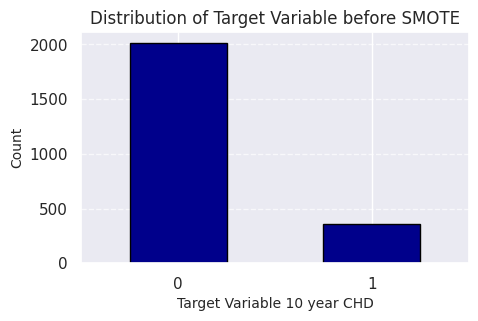

In [10]:
# visualize the target variable before SMOTE
plt.figure(figsize=(5, 3))
y_train.value_counts().plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Distribution of Target Variable before SMOTE', fontsize=12)
plt.xlabel('Target Variable 10 year CHD', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
# Oversampling using SMOTE
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Samples in the original dataset', len(y_train))
print('Samples in the resampled dataset', len(y_smote))

Samples in the original dataset 2373
Samples in the resampled dataset 4022


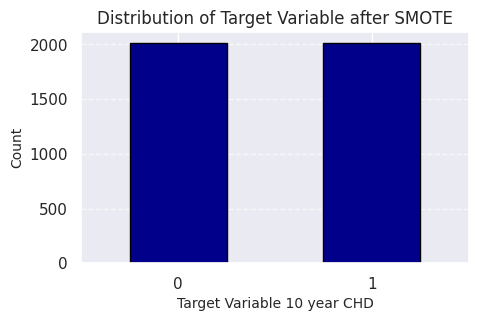

In [12]:
# visualize the target variable before SMOTE
plt.figure(figsize=(5, 3))
y_smote.value_counts().plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Distribution of Target Variable after SMOTE', fontsize=12)
plt.xlabel('Target Variable 10 year CHD', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
# Scaling data

# Scaling data for training set
scaler_train = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_var] = scaler_train.fit_transform(X_train[cont_var])

# Scaling data for SMOTE set
scaler_smote = StandardScaler()
X_smote_scaled = X_smote.copy()
X_smote_scaled[cont_var] = scaler_smote.fit_transform(X_smote[cont_var])

# Scaling data for test set
scaler_test = StandardScaler()
X_test_scaled = X_test.copy()
X_test_scaled[cont_var] = scaler_test.fit_transform(X_test[cont_var])



In [14]:
X_train_scaled.head()

,age,education,sex,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,bmi,heart_rate,glucose,pulse_pressure
1071,-1.287770,2,0,-0.886926,0,0,0,0,0.397068,0.941771,1.237733,-0.692125,-1.665090
3250,1.190333,2,0,1.149606,1,0,1,0,1.304954,-0.346214,1.237733,-1.910037,2.828386
2893,0.688116,1,1,1.149606,0,0,1,0,1.051634,-0.368797,0.013233,-1.172910,0.650239
1655,0.022609,3,1,0.589561,0,0,0,0,1.510730,0.214501,0.774053,-1.273363,0.379211
1419,-1.001256,1,0,1.790234,0,0,1,0,1.529069,2.887815,1.946501,-0.330954,2.481595


In [60]:
#evaluating model

def evaluate(C, X_train, y_train, X_test, y_test):
    # Train the classifier
    C.fit(X_train, y_train)

    # Get the predicted probabilities
    y_pred = C.predict(X_test)

    # Compute metrics
    train_recall = recall_score(y_train, C.predict(X_train))
    train_accuracy = accuracy_score(y_train, C.predict(X_train))
    test_recall = recall_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)


    # Print evaluation metrics
    print('ROC_AUC score - test dataset:', roc_auc_score(y_test, y_pred))
    print('Accuracy score - test dataset:', test_accuracy)

    # Summary
    print('\nSummary:')

    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Train Recall: {train_recall:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Recall: {test_recall:.4f}')


    # Classification report
    print('Classification report - test dataset: \n', classification_report(y_test, y_pred))

    return train_accuracy, test_accuracy, train_recall, test_recall




### K-nearest neighbor model

In [54]:
# Setup arrays to store training and test accuracies and recalls
neighbors = 50
train_accuracy = np.empty(neighbors)
test_accuracy = np.empty(neighbors)
train_recall = np.empty(neighbors)
test_recall = np.empty(neighbors)

for i in range(1, neighbors + 1):
    # Setup a knn classifier with k neighbors
    knn_model = KNeighborsClassifier(n_neighbors=i)

    # Fit the model
    knn_model.fit(X_smote_scaled, y_smote)

    # Compute accuracy on the training set
    train_accuracy[i - 1] = knn_model.score(X_smote_scaled, y_smote)

    # Compute accuracy on the test set
    test_accuracy[i - 1] = knn_model.score(X_test_scaled, y_test)

    # Compute recall on the training set
    knn_train_pred = knn_model.predict(X_smote_scaled)
    knn_train_recall = recall_score(y_smote, knn_train_pred)
    train_recall[i - 1] = knn_train_recall

    # Compute recall on the test set
    knn_test_pred = knn_model.predict(X_test_scaled)
    knn_test_recall = recall_score(y_test, knn_test_pred)
    test_recall[i - 1] = knn_test_recall


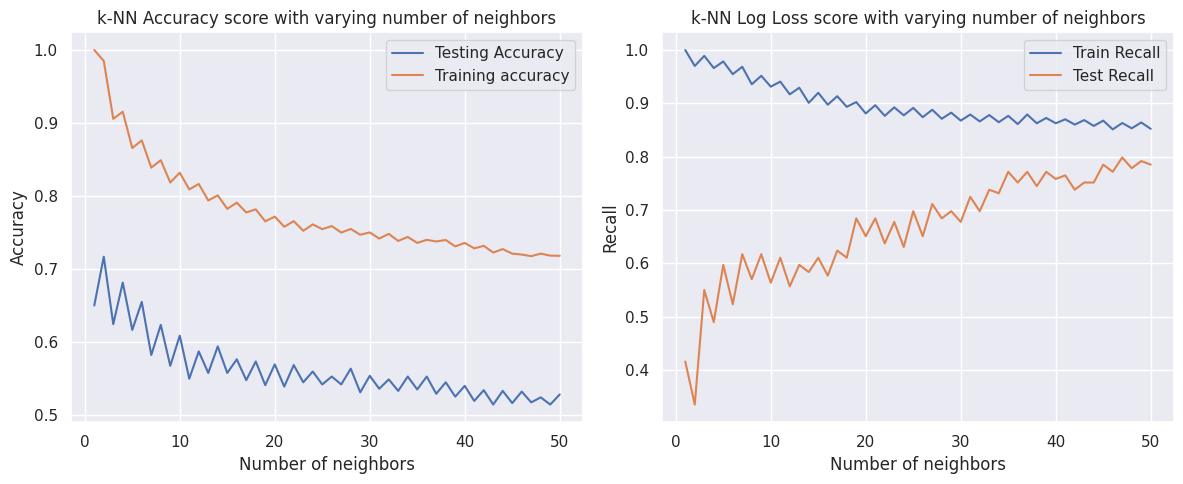

In [55]:
# Generate plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.set_title('k-NN Accuracy score with varying number of neighbors')
x_axis = [i for i in range(1, 51)]
ax1.plot(x_axis, test_accuracy, label='Testing Accuracy')
ax1.plot(x_axis, train_accuracy, label='Training accuracy')
ax1.legend()
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('Accuracy')

# Plot loss
ax2.set_title('k-NN Log Loss score with varying number of neighbors')
ax2.plot(x_axis, train_recall, label='Train Recall')
ax2.plot(x_axis, test_recall, label='Test Recall')
ax2.legend()
ax2.set_xlabel('Number of neighbors')
ax2.set_ylabel('Recall')

plt.tight_layout()
plt.show()


In [56]:
# Best k is where the test recall is the highest
best_k = knn_test_res.index(max(knn_test_res))+1
best_k

47

In [61]:
# building knn model with best parameters
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# evaluate model
knn_train_accuracy, knn_test_accuracy, knn_train_recall, knn_test_recall = evaluate(knn_model, X_smote_scaled, y_smote, X_test_scaled, y_test)


ROC_AUC score - test dataset: 0.6337758636686976
Accuracy score - test dataset: 0.5172074729596854

Summary:
Train Accuracy: 0.7176
Train Recall: 0.8633
Test Accuracy: 0.5172
Test Recall: 0.7987
Classification report - test dataset: 
               precision    recall  f1-score   support

           0       0.93      0.47      0.62       868
           1       0.21      0.80      0.33       149

    accuracy                           0.52      1017
   macro avg       0.57      0.63      0.48      1017
weighted avg       0.82      0.52      0.58      1017



[[407 461]
 [ 30 119]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

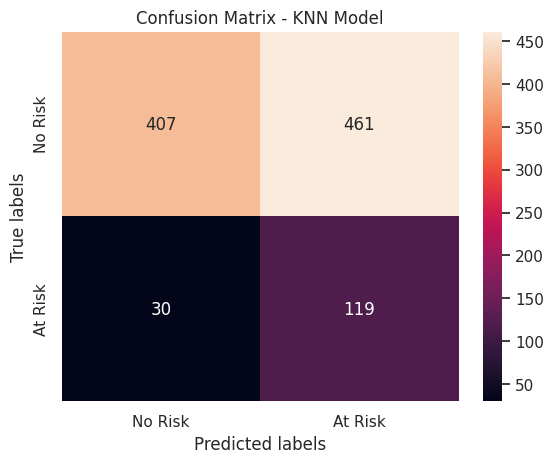

In [62]:
# Get the confusion matrix for test
# Test predictions
knn_test_pred = knn_model.predict(X_test_scaled)

labels = ['No Risk', 'At Risk']
cm = confusion_matrix(y_test, knn_test_pred)
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d')  # annot=True to annotate cells

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - KNN Model')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


False negatives obtained after using KNN: 30

False positives obtained after using KNN: 461 (very high!)

### Random Forest Classifier

In [27]:
# random forest model
rf_model = RandomForestClassifier(random_state=0)
rf_params = {'n_estimators':[500],
             'max_depth':np.arange(1,6),
             'min_samples_split':np.arange(0.1,1,0.1),
             'min_samples_leaf':np.arange(0.1,0.6,0.1)}


In [29]:
#less parameters for faster grid search
rf_model = RandomForestClassifier(random_state=0)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': np.arange(1, 4),  # Reduced range
    'min_samples_split': np.arange(0.1, 0.6, 0.2),  # Reduced range and step size
    'min_samples_leaf': np.arange(0.1, 0.4, 0.2)  # Reduced range and step size
}


In [30]:
#specify the cross-validation strategy
cv_method = RepeatedStratifiedKFold(n_splits=4,
                                    n_repeats=3,
                                    random_state=0)


In [ ]:
# using gridsearchcv to find best parameters
rf_gridsearch = GridSearchCV(rf_model,rf_params,cv=cv_method,scoring='recall')
rf_gridsearch.fit(X_smote_scaled,y_smote)
rf_best_params = rf_gridsearch.best_params_

In [ ]:
# best parameters for random forests
rf_best_params

In [ ]:
# Fitting RF model with best parameters
rf_model = RandomForestClassifier(n_estimators=rf_best_params['n_estimators'],
                                  min_samples_leaf=rf_best_params['min_samples_leaf'],
                                  min_samples_split=rf_best_params['min_samples_split'],
                                  max_depth=rf_best_params['max_depth'],
                                  random_state=0)

In [ ]:
# fit and evaluate
rf_model.fit(X_smote_scaled,y_smote)
evaluate(rf_model, X_test_scaled, y_test)
rf_train_accuracy, rf_test_accuracy,, rf_train_recall, rf_test_recall = recall(rf_model, X_smote_scaled, y_smote, X_test, y_test)

In [ ]:
# Feature importances
rf_feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: RANDOM FORESTS')
plt.xlabel('Relative Importance')
rf_feat_imp.nlargest(20).plot(kind='barh')

In [ ]:
# Get the confusion matrix for test dataset for random forest model

rf_test_pred = rf_model.predict(X_test_scaled)

labels = ['No Risk', 'At Risk']
cm = confusion_matrix(y_test, rf_test_pred)
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix -  Random Forest Model')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


## XGBoost (Extreme Gradient Boosting)

-optimized distributed gradient boosting library

-builds an ensemble of decision trees sequentially, where each tree corrects the errors of the previous one

In [63]:
# XGBOOST model
xgb_model = xgb.XGBClassifier(random_state=0)
xgb_params = {'n_estimators':[500],
             'max_depth':[1],
             'min_samples_split':np.arange(0.1,1,0.1),
             'min_samples_leaf':np.arange(0.1,0.6,0.1)}

In [ ]:
# using gridsearchcv to find best parameters
xgb_gridsearch = GridSearchCV(xgb_model,xgb_params,cv=cv_method,scoring='recall')
xgb_gridsearch.fit(X_smote_scaled,y_smote)
xgb_best_params = xgb_gridsearch.best_params_

In [ ]:
# best parameters for xgboost classifier
xgb_best_params

In [ ]:
# Fitting xgb with best parameters
xgb_model = xgb.XGBClassifier(n_estimators=xgb_best_params['n_estimators'],
                                  min_samples_leaf=xgb_best_params['min_samples_leaf'],
                                  min_samples_split=xgb_best_params['min_samples_split'],
                                  max_depth=xgb_best_params['max_depth'],
                                  random_state=0)

In [ ]:
# fit and evaluate
xgb_model.fit(X_smote_scaled, y_smote)

evaluate(xgb_model, X_test_scaled, y_test)
xgb_train_accuracy, xgb_test_accuracy, xgb_train_recall, xgb_test_recall = recall(xgb_model, X_smote_scaled, y_smote, X_test, y_test)
#xgb_train_pred = [round(value) for value in xgb_train_pred]


In [ ]:
# Get the confusion matrix for test dataset for gradient boosting

xgb_test_pred = xgb_model.predict(X_test_scaled)

labels = ['No Risk', 'At Risk']
cm = confusion_matrix(y_test, xgb_test_pred)
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d')  # annot=True to annotate cells

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - XGBoost')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


## Results

In [ ]:
# Summarizing the results obtained
test = PrettyTable(['Sl. No.','Classification Model', 'Train Recall (%)','Test Recall (%)'])
test.add_row(['1','K Nearest Neighbors',knn_train_recall*100,knn_test_recall*100])
test.add_row(['2','Random Forests',rf_train_recall*100,rf_test_recall*100])
test.add_row(['3','XG Boost',xgb_train_recall*100,xgb_test_recall*100])
print(test)

In [ ]:
# Summarizing the results obtained
test = PrettyTable(['Sl. No.','Classification Model', 'Train Accuracy (%)','Test Accuracy (%)'])
test.add_row(['1','K Nearest Neighbors',knn_train_accuracy*100,knn_test_accuracy*100])
test.add_row(['2','Random Forests',rf_train_accuracy*100,rf_test_accuracy*100])
test.add_row(['3','XG Boost',xgb_train_accuracy*100,xgb_test_accuracy*100])
print(test)

## Testing whether neural networks aim better results than classifiers

In [ ]:
#load helper functions
%run '/content/drive/My Drive/Colab Notebooks/helper_functions_tabular.py'
%run '/content/drive/My Drive/Colab Notebooks/neural_network_tabular.py'

save_path = '/content/drive/My Drive/heart_disease/'

In [ ]:
#Create an instance of Model
model = Model()
model.to(device)
print(model.parameters)

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (fc2): Linear(in_features=26, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=2, bias=True)
)>


In [ ]:
# Convert features and labels to tensors
X_train_nn = torch.FloatTensor(X_smote_scaled.values)
X_test_nn = torch.FloatTensor(X_test_scaled.values)
y_train_nn = torch.LongTensor(y_smote.values)  # Convert to LongTensor
y_test_nn = torch.LongTensor(y_test.values)  # Convert to LongTensor

# Ensure y_train and y_test are 1D tensors
y_train_nn = torch.squeeze(y_train_nn)
y_test_nn = torch.squeeze(y_test_nn)

In [ ]:
sample_ratio = 0.4
batch_size = 10 #smaller size to ensure better convergence
num_epochs = 1000 #if computational cost would not matter, good practice would be to observe when the model does not get any better

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# set the criterion of the model to measure the error
criterion = nn.CrossEntropyLoss()

#Choose adam optimizer, lr=learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#criterion and optimizer are inputs of the train function
model_name = "Simple_NN"
losses, accuracies, v_accuracies, v_losses = train_model(model, X_train_nn, y_train_nn, X_test_nn, y_test_nn, model_name, save_path, optimizer, criterion, device, num_epochs, 'Train')

#Save pre-trained model to file
torch.save(model.state_dict(), "{}{}.pth".format(save_path, model_name))

Train: Accuracy: 0.5939 | Loss: 0.0007 | Recall: 0.5898 | Precision: 0.5458 | F-score: 0.5055

Epoch 1/1000, Train Loss: 0.5671831369400024, Train Accuracy: 0.7389358528095475, Validation Loss: 0.0006768983608384634, Validation Accuracy: 0.5939036381514258
Train: Accuracy: 0.5939 | Loss: 0.0007 | Recall: 0.5898 | Precision: 0.5458 | F-score: 0.5055

Epoch 2/1000, Train Loss: 0.5671560168266296, Train Accuracy: 0.7386872202884137, Validation Loss: 0.0006768048219858955, Validation Accuracy: 0.5939036381514258
Train: Accuracy: 0.5939 | Loss: 0.0007 | Recall: 0.5898 | Precision: 0.5458 | F-score: 0.5055

Epoch 3/1000, Train Loss: 0.5671288967132568, Train Accuracy: 0.7386872202884137, Validation Loss: 0.0006767718841192645, Validation Accuracy: 0.5939036381514258
Train: Accuracy: 0.5939 | Loss: 0.0007 | Recall: 0.5898 | Precision: 0.5458 | F-score: 0.5055

Epoch 4/1000, Train Loss: 0.567101776599884, Train Accuracy: 0.7386872202884137, Validation Loss: 0.0006767790343323054, Validation Ac

In [ ]:
model_name = "Simple NN"
plot_model_curves(losses, accuracies, v_accuracies, v_losses, data_path, model_name)